# **A Multi-Label Dataset of French Fake News**

This NLP project was carried out as part of the *"Machine Learning for NLP"* course in the second year of the master's program at ENSAE. It is based on the paper [**A Multi-Label Dataset of French Fake News: Human and Machine Insights**](https://arxiv.org/abs/2403.16099) by Icard et al. (2024), and uses the associated GitHub repository [**OBSINFOX**](https://github.com/obs-info/obsinfox), which provides both the dataset used in this study and its accompanying documentation.

---

### Dataset Overview — OBSINFOX

* **Labels**: 11 distinct labels annotated for each document, with detailed definitions provided in the paper and repository README.
* **Metadata**: title, annotator ID, article URL.
* **Sources**: The dataset includes articles from **17 French media sources** identified as unreliable by watchdog organizations such as *NewsGuard* and *Conspiracy Watch*.

The dataset consists of **100 documents** carefully selected from the aforementioned sources using a specific methodology, which will be explained later in the notebook.

---

### Why This Dataset Matters for Fake News Detection

This dataset provides a rich foundation for studying how linguistic cues can signal that a text is **counterfactual**, **subjective**, or **satirical**. Several key aspects make it particularly valuable:

* Each document is annotated along **11 complementary dimensions**, encompassing linguistic, stylistic, and factual properties.
* Annotations were conducted by a panel of **8 expert annotators**, ensuring high-quality and nuanced evaluation.
* The multi-label structure enables **multi-dimensional analysis** of fake news, capturing not only factual inaccuracies but also subtleties of tone, exaggeration, and bias.

As such, OBSINFOX serves as a powerful resource for training and evaluating models capable of detecting weak signals of misinformation and editorial bias in French-language news content.

---

### *Importing Required Packages*

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import time

## Data manipulation
from statsmodels.stats.inter_rater import fleiss_kappa
from sklearn.metrics import cohen_kappa_score
import krippendorff

## NLP & Text processing
import re
from collections import Counter
import nltk
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = list(set(stopwords.words('french')))
#from gensim.models.phrases import Phrases, Phraser
from string import punctuation
punctuation = list(punctuation)
from sklearn.feature_extraction.text import CountVectorizer

## Scrapping & APIs
import requests
from newspaper import Article


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tomrossa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### **Preprocessing the OBSINFOX Dataset**

In this section, we begin by importing the OBSINFOX dataset and applying an initial round of preprocessing to prepare the data for analysis and modeling.

The preprocessing pipeline will include the following steps:

1. **Loading the dataset**: Reading the structured data and metadata from the OBSINFOX repository.

3. **Normalization**: Lowercasing text and standardizing punctuation to reduce vocabulary size.

4. **Exploratory filtering**: Ensuring the dataset is consistent and complete by removing empty or malformed entries.


This stage is essential to ensure the quality and consistency of the textual data before moving on to any linguistic analysis or model training.

---

In [41]:
df = pd.read_csv('obsinfox.csv')
df.head()

,URL,Title,Fake News,"Places, Dates, People",Facts,Opinions,Subjective,Reported information,Sources Cited,False Information,Insinuation,Exaggeration,Offbeat Title,Annotator
0,https://lesakerfrancophone.fr/la-relation-entr...,La relation entre la technologie et la religion,0,1,1,1,1,0,1,0,0,0,0,rater1
1,https://www.breizh-info.com/2021/01/27/157958/...,"Confinement. Les habitants de Brest, Morlaix e...",0,1,1,0,0,0,1,0,0,0,0,rater1
2,https://reseauinternational.net/la-chine-le-pr...,La Chine : Le premier marché mondial de Smartp...,0,1,1,0,0,0,1,0,0,0,0,rater1
3,https://lezarceleurs.blogspot.com/2021/12/emma...,"Emmanuel à Olivier : « Tiens bon, on les aura ...",1,1,1,1,1,0,0,1,0,1,0,rater1
4,https://lesakerfrancophone.fr/selon-ubs-les-pr...,"Selon UBS, les « propriétés d’assurance tant d...",0,1,1,1,1,0,1,0,0,0,0,rater1


#### *Metadonnées & Labels*

Chaque ligne du dataset contient les différentes annotations réalisées pour un texte et un annotateur. La construction du dataset inclut des métadonnées visant à donner du contexte aux différents textes : titre, URL, ainsi que l'ID anonyme de l'annotateur. Il y a donc 800 lignes dans le dataset correspondant aux 100 textes annotés par 8 personnes. 

The OBSINFOX dataset includes eleven distinct labels that capture various **factual**, **stylistic**, and **interpretative** features of news articles. These labels were designed to reflect both the objective content and the subjective framing often present in fake or misleading news. Below is a description of each label:


* **Fake News**
  The article contains at least one false or exaggerated fact.

* **Places, Dates, People**
  The article refers to at least one identifiable place, date, or person.

* **Facts**
  The article reports at least one factual element — that is, a state of affairs or event, whether true or false.

* **Opinions**
  The article expresses at least one opinion, judgment, or personal interpretation.

* **Subjective**
  The article contains more opinions than verifiable facts, highlighting a subjective tone or perspective.

* **Reported Information**
  The article relays information that is attributed to an external source and is not directly endorsed by the author.

* **Sources Cited**
  The article includes at least one cited source that supports or contextualizes a factual claim.

* **False Information**
  The article contains information that is demonstrably false or factually incorrect.

* **Insinuation**
  The article implies or suggests a certain interpretation without stating it explicitly.

* **Exaggeration**
  The article presents a real fact using language or framing that amplifies or distorts its significance.

* **Offbeat Title**
  The article has a misleading or sensational headline that does not accurately reflect the actual content.

These labels aim to offer a nuanced characterization of the articles' content. Some of them are **objectively measurable** (e.g., *Places, Dates, People*, *Facts*, *Sources Cited*), while others are more **subject to interpretation**, reflecting the annotators’ perception and judgment.

Studying the **co-occurrence patterns** among these labels provides valuable insight into how alternative or misleading news content is structured and perceived by human readers.

In [42]:
print(" DataFrame Summary")
print("="*40)
print(f"Number of rows    : {df.shape[0]}")
print(f"Number of columns : {df.shape[1]}")
print("\n Column List: \n")

for i, col in enumerate(df.columns):
    print(f"{i+1:>2}. {col}")


 DataFrame Summary
Number of rows    : 800
Number of columns : 14

 Column List: 

 1. URL
 2. Title
 3. Fake News
 4. Places, Dates, People
 5. Facts
 6. Opinions
 7. Subjective
 8. Reported information
 9. Sources Cited
10. False Information
11. Insinuation
12. Exaggeration
13. Offbeat Title
14. Annotator


Du fait de sa petite taille, les données dans le dataset sont très qualitatives avec aucune valeur manquante et aucune duplication de lignes, ce qui facilite l'étape de nettoyage dans le preprocessing. 

In [43]:
df.isna().sum()

URL                      0
Title                    0
Fake News                0
Places, Dates, People    0
Facts                    0
Opinions                 0
Subjective               0
Reported information     0
Sources Cited            0
False Information        0
Insinuation              0
Exaggeration             0
Offbeat Title            0
Annotator                0
dtype: int64

In [44]:
df.duplicated().sum()

0

Pour avoir une facilité d'accès aux différentes annotations pour un article spécifique, on ajoute au dataframe une colonne ``article_ID`` qui identifie de manière unique les 100 textes présents ici. 

In [45]:
df['Article ID'] = df.index % 100

#### *Article Text Extraction with `newspaper3k`*

As the next steps of our project rely on analyzing the full content of the articles, we will need access to the actual **text of each news article**. Since our dataset only includes the article URLs, we will use the Python library [`newspaper3k`](https://github.com/codelucas/newspaper) to automatically **scrape and extract the main text content** from each webpage.

`newspaper3k` is a Python library designed for **fast, simple, and efficient extraction of web articles**. It is the third iteration of the `newspaper` project, created by **Lucas Ou-Yang**. It is widely used in the NLP and data journalism communities for tasks such as:

* Automatic article text extraction
* Metadata collection (title, author, publish date, etc.)
* Downloading and parsing articles with minimal setup
* Multilingual support (to some extent)

The library uses a combination of **HTML parsing**, **content heuristics**, and **natural language processing** techniques to identify the main textual body of an article and remove noise (e.g., ads, navigation, comments). Here's a simplified workflow:

1. Provide a URL to `newspaper.Article()`.
2. Download the HTML content using `.download()` (in RAM memory).
3. Parse the article structure with `.parse()`.
4. Extract the cleaned article text using `.text`.

This extracted text will then be **preprocessed and cleaned** before being fed into the various NLP models used in our analysis pipeline.

In [46]:
def extract_text_from_url(url):
    try:
        article = Article(url)
        article.download()
        article.parse()
        return article.text
    except:
        return None

extract_text_from_url(df.iloc[0]['URL'])

'Par Austin Cline − Le 27 fevrier 2019 − Source Learn Religions\n\nDe nombreux laïcs et non-croyants de toutes sortes ont tendance à considérer la religion et la science comme fondamentalement incompatibles. Cette incompatibilité est également imaginée pour s’étendre à la relation entre la religion et la technologie, puisque la technologie est un produit de la science et que la science ne peut pas aller de l’avant sans la technologie, surtout aujourd’hui. Ainsi, bon nombre d’athées s’émerveillent avec incrédulité du nombre d’ingénieurs qui sont également des créationnistes et du nombre de personnes dans les industries de haute technologie qui affichent de grandes motivations religieuses.\n\nMélanger technologie et religion\n\nPourquoi assistons-nous à un enchantement généralisé pour la technologie et en même temps à une résurgence mondiale du fondamentalisme religieux ? Nous ne devrions pas supposer que la montée des deux est simplement une coïncidence. Au lieu de présumer que l’éducat

On applique cette fonction à l'ensemble des URLs dans le dataset, et on ajoute une colonne `text` où figurera donc le contenu des différents articles. 

In [47]:
tqdm.pandas()

urls = df['URL'].drop_duplicates().head(100)

url_to_text = {}

for url in tqdm(urls):
    url_to_text[url] = extract_text_from_url(url)

100%|██████████| 100/100 [02:55<00:00,  1.76s/it]


In [48]:
df['text'] = df['URL'].map(url_to_text)

print("Number of Missing Texts \n")

df.iloc[0:100]['text'].isna().sum()


Number of Missing Texts 



21

Preprocessing des textes : 

On définit une suite de fonctions de preprocessing pour nettoyer les textes et les rendre exploitables par des méthodes NLP. Notamment on

- Mettre les textes en minuscule
- Remove URL tags
- Remove Hashtags
- Remove @
- Remove Brackets
- Remove Punctuation 

In [49]:
stopwords = stopwords + punctuation + ['“','’', '“', '”', '‘','...']

def lowerizer(article):
  """
  Lowerize a given text
  """
  return article.lower()

def remove_url(article):
    """
    Remove URL tags 
    """
    article = re.sub(r'https?:\/\/.\S+', "", article)
    return article

def remove_hashtags(article):
    """
    Remove hashtags from a given text
    """
    article = re.sub("#"," ",article)
    return article

def remove_a(article):
    """
    Remove twitter account references @ rom a given text
    """
    article = re.sub("@"," ",article)
    return article

def remove_brackets(article):
    """
    Remove square brackets from a given text 
    """
    article = re.sub('\[[^]]*\]', '', article)
    return article

def remove_stop_punct(article):
    """
    Remove punctuation and stopwords from a given text
    """
    final_article = []
    for i in article.split():
        if i not in stopwords:
            final_article.append(i.strip())
    return " ".join(final_article)

def preprocessing(article):
    """
    Computes the above-define steps to clean a given text
    """
    article = lowerizer(article)
    article = remove_url(article)
    article = remove_hashtags(article)
    article = remove_a(article)
    article = remove_brackets(article)
    article = remove_stop_punct(article)
    return article

On présente quelques manipulation typique que l'on peut faire sur le dataset à travers quelques exemples: 

- On peut faire la moyenne des annotations réalisées par un annotateur à des fins de comparaison (certains vont être plus critiques par exemple)
- Pour un article donné, on peut comparer les annotations 

In [50]:
cols = df.columns[2:13]  
grouped_means = df.groupby('Annotator')[cols].mean()

print("Mean values by Annotator for selected columns")
display(grouped_means)

Mean values by Annotator for selected columns


,Fake News,"Places, Dates, People",Facts,Opinions,Subjective,Reported information,Sources Cited,False Information,Insinuation,Exaggeration,Offbeat Title
Annotator,,,,,,,,,,,
rater1,0.21,0.90,0.93,0.80,0.71,0.14,0.75,0.08,0.22,0.37,0.03
rater2,0.29,0.94,0.99,0.93,0.74,0.21,0.82,0.09,0.24,0.44,0.21
rater3,0.64,1.00,0.96,0.74,0.63,0.14,0.68,0.46,0.46,0.61,0.14
rater4,0.34,1.00,1.00,0.87,0.52,0.22,0.87,0.32,0.54,0.42,0.16
rater5,0.47,0.93,0.96,0.66,0.67,0.76,0.76,0.22,0.73,0.53,0.17
rater6,0.34,0.75,0.93,0.72,0.60,0.21,0.60,0.11,0.42,0.35,0.04
rater7,0.29,1.00,0.91,0.45,0.47,0.66,0.78,0.24,0.43,0.35,0.01
rater8,0.44,1.00,0.99,0.66,0.48,0.11,0.46,0.34,0.59,0.52,0.08


On remarque bien que certains annotateurs peuvent être beaucoup plus parcimonieux pour attribuer certains labels que les autres. Ce n'est pas directement lié au degré d'accord entre eux puisque l'on ne quantifie pas à quel point est ce qu'ils décrivent de façon similaire tel ou tel article, mais si de façon générale ils ont plus ou moins tendance à attribuer chacun des labels. 

Sur le graphique suivant, on voit par exemple que le rater 5 et 7 attribuent beaucoup plus souvent que les autres le label ``Reported Information``, ou encore que le rater 1 et 7 attribuent beaucoup moins souvent que les autres le label ``Offbeat Title``. Cela peut être important à savoir au moment de l'analyse. 

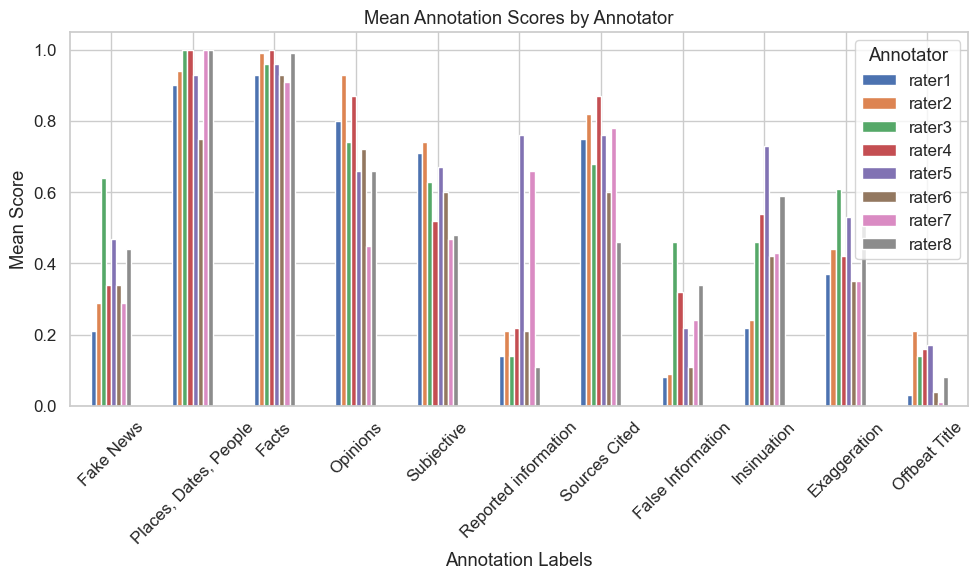

In [51]:
grouped_means.T.plot(kind='bar', figsize=(10, 6))

plt.title("Mean Annotation Scores by Annotator")
plt.xlabel("Annotation Labels")
plt.ylabel("Mean Score")
plt.xticks(rotation=45)
plt.legend(title="Annotator")
plt.tight_layout()
plt.show()

Regardons les différentes annotations pour l'article 1. Il est assez clair que pour chacun des labels, la majorité des annotateurs sont d'accord mais pas toujours à l'unanimité sur l'attribution du label. Par exemple, 3 annotateurs considèrent que l'article insinue ou suggère une certaine interprétation d'un fait. Ou encore, l'un des annotateur considère qu'il contient une fausse information. On voit donc que même pour des catégorie dont on pourrait croire qu'elle est assez objectif (``False Information``), on peut avoir des opinions contradictoires parmis les annotateurs. 

In [52]:
row_article_1 = df.iloc[[0, 100, 200, 300, 400, 500, 600, 700]]

print("Different Annotators for the same article")
row_article_1[row_article_1.columns[2:13]]

Different Annotators for the same article


,Fake News,"Places, Dates, People",Facts,Opinions,Subjective,Reported information,Sources Cited,False Information,Insinuation,Exaggeration,Offbeat Title
0,0,1,1,1,1,0,1,0,0,0,0
100,0,1,1,1,1,0,1,0,0,0,0
200,0,1,1,1,1,0,1,0,0,0,0
300,0,1,1,1,1,0,1,0,1,0,0
400,0,1,0,1,1,1,1,0,0,0,0
500,0,1,1,1,1,0,1,0,0,0,0
600,0,1,1,1,1,1,1,0,1,0,0
700,1,1,1,1,1,0,0,1,1,1,0


Regardons la proportion des différents labels dans le dataset. Pour cela, on construit un dictionnaire qui associe pour chacun des labels une colonne qui contient la proportion des annotateurs l'ayant attribué à chacun des articles. 

On regarde par exemple : 
- le nombre d'articles pour lesquels la majorité des annotateurs disent qu'il contient une fake news et on compare à la proportion attendue de par la construction de l'article. 
- Tous les autres


Proportion of Fake News in Dataset

0.31

 Cumulative Sum of Fake News Annotations



/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_48361/1997172731.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="Blues_d")


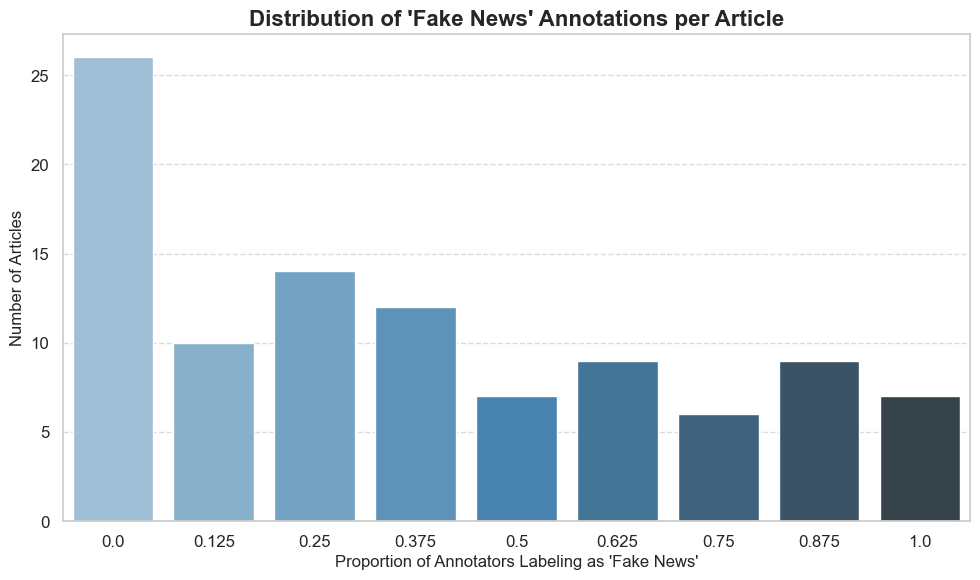

In [53]:
annotations_per_article = {}

for i, col in enumerate(row_article_1.columns[2:13]):
    annotations_per_article[col] = df.groupby('Article ID')[col].mean()

print("Proportion of Fake News in Dataset\n")

print(sum(annotations_per_article['Fake News'] > 0.5) / 100)

print("\n Cumulative Sum of Fake News Annotations\n")
sns.set(style="whitegrid", font_scale=1.1)
counts = annotations_per_article['Fake News'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
sns.barplot(x=counts.index, y=counts.values, palette="Blues_d")
plt.title("Distribution of 'Fake News' Annotations per Article", fontsize=16, weight='bold')
plt.xlabel("Proportion of Annotators Labeling as 'Fake News'", fontsize=12)
plt.ylabel("Number of Articles", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

On observe ici que la proportion d'article dont les annotateurs pensent en majorité qu'ils contiennent une fake news est de 31%, ce qui est inférieur à la proportion que l'on pourrait attendre de par la construction du dataset. En effet, les 100 articles présents dans le datasets ont été selectionnés initialement parmi un corpus de plus de 50k documents. Selon une étude préalable, 50% des articles contiennent une fake news avec forte probabilité (> 0.8) et 50% une faible probabilité d'en contenir (< 0.2). 

In [54]:
summary = {}

for col in df.columns[2:13]:
    proportion = (annotations_per_article[col] > 0.5).sum() / 100
    summary[col] = round(proportion, 2)

summary_df = pd.DataFrame.from_dict(summary, orient='index', columns=['Proportion > 0.5'])
summary_df.index.name = "Label"
summary_df = summary_df.sort_values(by='Proportion > 0.5', ascending=False)

summary_df.style.bar(subset=["Proportion > 0.5"], color='#5B9BD5')\
                .format("{:.0%}")\
                .set_caption("Proportion of Articles with Majority Vote per Label")


,Proportion > 0.5
Label,
"Places, Dates, People",99%
Facts,98%
Sources Cited,73%
Opinions,69%
Subjective,60%
Insinuation,44%
Exaggeration,40%
Fake News,31%
Reported information,14%


#### *Fleiss' Kappa: Measuring Inter-Annotator Agreement*

**Fleiss' Kappa** is a statistical measure used to evaluate the **degree of agreement between multiple annotators** when assigning categorical labels (e.g., binary values 0/1) to a fixed number of items.

Unlike Cohen's Kappa (which is limited to two annotators), Fleiss' Kappa generalizes to any number of annotators, assuming that:

* Each item is annotated by the **same number of annotators**,
* The annotation is **categorical** (nominal),
* For each item, we count how many annotators chose each category (e.g., how many voted 0 vs. 1).

The coefficient is then computed by comparing:

* The **observed agreement** (how often annotators agree),
* The **expected agreement by chance** (based on category prevalence).

$$
\kappa = \frac{\bar{P} - P_e}{1 - P_e}
$$

Where:

* $\bar{P}$ is the **mean observed agreement** across all items:

$$
\bar{P} = \frac{1}{N} \sum_{i=1}^N P_i
\quad \text{with} \quad
P_i = \frac{1}{n(n-1)} \sum_{j=1}^k n_{ij}(n_{ij} - 1)
$$

* $P_e$ is the **expected agreement by chance**:

$$
P_e = \sum_{j=1}^k p_j^2
\quad \text{where} \quad
p_j = \frac{1}{Nn} \sum_{i=1}^N n_{ij}
$$

And:

* $N$ = number of items
* $n$ = number of annotators per item
* $k$ = number of categories (e.g., 2 for binary labels)
* $n_{ij}$ = number of annotators who assigned category $j$ to item $i$

The value of Fleiss’ Kappa ranges from -1 (complete disagreement) to 1 (perfect agreement), with 0 indicating no better agreement than random chance.

In [55]:
def prepare_matrix_for_fleiss(df_binary):
    
    counts_1 = df_binary * 8
    counts_0 = 8 - counts_1
    return np.vstack([counts_0, counts_1]).T

In [56]:
results = {}

for col in df.columns[2:13]:

    df_binary = prepare_matrix_for_fleiss(annotations_per_article[col])
    kappa = fleiss_kappa(df_binary)
    results[col] = kappa

results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Fleiss Kappa'])
results_df.index.name = "Label"
results_df = results_df.sort_values(by='Fleiss Kappa', ascending=False)
results_df.style.bar(subset=["Fleiss Kappa"], color='#5B9BD5')\
                .format("{:.2f}")\
                .set_caption("Fleiss Kappa for Each Label")




,Fleiss Kappa
Label,
Subjective,0.54
Exaggeration,0.46
Fake News,0.39
Opinions,0.36
False Information,0.31
Insinuation,0.26
Sources Cited,0.25
Reported information,0.17
Offbeat Title,0.12


On remarque ici que le kappa Fleiss est assez délicat à interpréter puisqu'il est très sensible aux déséquilibres des classes. Par exemple, tous les annotateurs attribuent à quasiment tous les articles le label ``Places, Dates, People``. Ainsi, cette classe est très déséquilibrée, donc la variable $P_e$ d'expected agreement by chance est très proche de 1. Selon ce coefficients, les labels sur lesquels les annotateurs seraient le plus en accord seraient ``Subjective``, ``Exaggeration`` et ``Fake News``. 

---

Désormais, on utilise la deuxième méthode développée dans l'article qui correspond à la proportion rescaled des attribution de label des annotateurs. Il s'agit d'une métrique plus naturelle qui consiste en 

- Calcul pour chaque article et chaque label la proportion des annotateurs l'ayant attribué : $x$
- On applique la transformation : $\alpha(x) = |2x - 1|$

Ainsi, plus les proportions sont proches de 1 et 0, plus on considère que les annotateurs sont d'accord. Si jamais la moitié d'entre eux attribue le label, alors on se retrouve avec un niveau d'agreement de 0. Ensuite, pour aggréger les résultats, on moyennise ce score sur l'ensemble des articles pour obtenir le graphique suivant. 

In [57]:
results_agreement = {}

for col in df.columns[2:13]:
    results_agreement[col] = np.abs(annotations_per_article[col] * 2 - 1).mean()

results_agreement_df = pd.DataFrame.from_dict(results_agreement, orient='index', columns=['Mean Agreement'])
results_agreement_df.index.name = "Label"
results_agreement_df = results_agreement_df.sort_values(by='Mean Agreement', ascending=False)
results_agreement_df.style.bar(subset=["Mean Agreement"], color='#5B9BD5')\
                .format("{:.2f}")\
                .set_caption("Mean Agreement for Each Label")

,Mean Agreement
Label,
Facts,0.92
"Places, Dates, People",0.88
Offbeat Title,0.80
Subjective,0.71
False Information,0.68
Opinions,0.67
Exaggeration,0.63
Fake News,0.62
Sources Cited,0.59


As expected, annotators tend to agree more strongly on objective labels such as **`Facts`** and **`Places, Dates, People`**, which are also among the most frequently assigned labels. These categories are typically grounded in observable and verifiable content, which naturally leads to higher consensus.

However, the agreement score for the label **`Fake News`** reaches only **0.62**, and for **`Insinuation`**, it drops to **0.51**. While these values still indicate moderate agreement, they reveal the **inherent subjectivity** of such categories. Even well-trained annotators may **struggle to consistently identify** insinuation or misinformation, as such judgments depend heavily on context, tone, and interpretation.

---

Below, we visualize the **distribution of agreement scores** across the 100 articles for each label using boxplots.

Take the **`Fake News`** label as an example:

* The **median agreement score** is relatively high (around **0.78**),
* But the **first quartile** drops significantly (around **0.25**),
* This spread indicates that while annotators often agree on whether an article contains fake news, there is a substantial portion (\~25%) of articles where their judgments diverge sharply.

This suggests that certain articles are particularly **polarizing** or ambiguous — even among domain experts — and may require **subjective interpretation** or reveal **biases in perception**.

/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_48361/1828161214.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_melted, x='Label', y='MeanScore', palette='pastel')


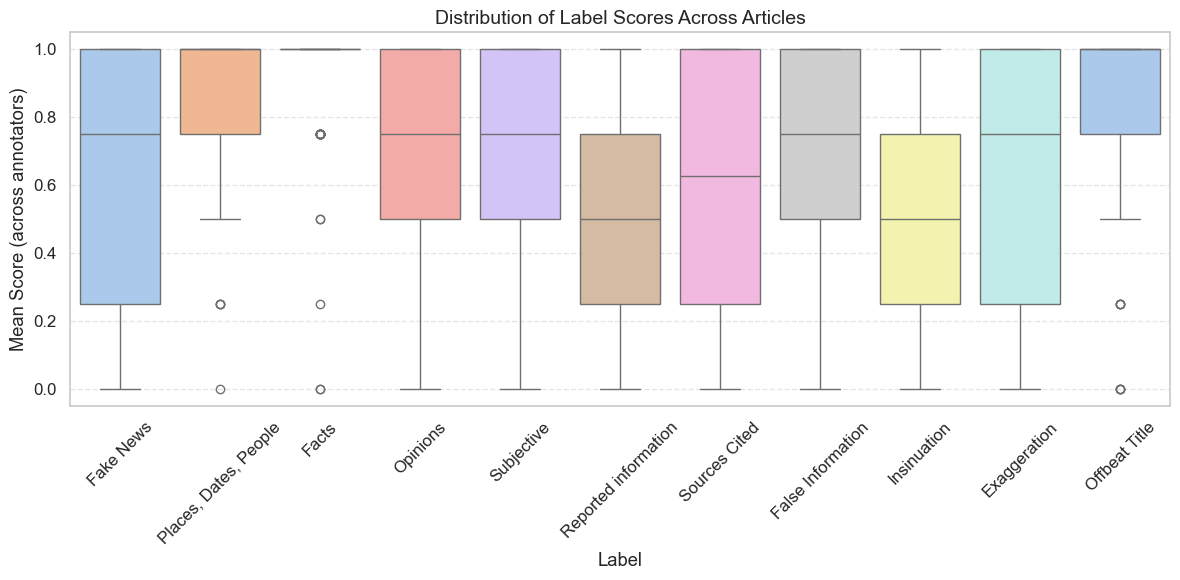

In [58]:
annotations_per_article_bis = {}

for col in df.columns[2:13]:
    annotations_per_article_bis[col] = np.abs(annotations_per_article[col] * 2 - 1)

df_labels = pd.DataFrame(annotations_per_article_bis)
df_labels = df_labels.reset_index()
df_labels = df_labels.rename(columns={'index': 'Article ID'})
df_labels = df_labels.set_index('Article ID')

df_melted = df_labels.melt(var_name='Label', value_name='MeanScore')

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melted, x='Label', y='MeanScore', palette='pastel')

plt.title("Distribution of Label Scores Across Articles", fontsize=14)
plt.xticks(rotation=45)
plt.xlabel("Label")
plt.ylabel("Mean Score (across annotators)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


On observe ensuite la matrice de corrélation entre les différents annotateurs pour le label ``Fake News``. Cela permet de voir si certains annotateurs sont très corrélés, c'est-à-dire qu'ils attribuent très souvent le même label ou non. 

In [59]:
fake_news = []

for i in range(8): 
    fake_news.append(np.array(df['Fake News'].iloc[i*100 : (i+1)*100]))

print("Correlation Matrix between Annotators for Fake News Annotations\n")
pd.DataFrame(fake_news).T.corr().style.background_gradient(cmap='coolwarm', low=0, high=1)

Correlation Matrix between Annotators for Fake News Annotations



,0,1,2,3,4,5,6,7
0,1.000000,0.373875,0.284387,0.407369,0.350735,0.407369,0.373875,0.235431
1,0.373875,1.000000,0.387501,0.285646,0.502048,0.332169,0.514327,0.499020
2,0.284387,0.387501,1.000000,0.450347,0.539305,0.450347,0.479326,0.371014
3,0.407369,0.285646,0.450347,1.000000,0.592993,0.509804,0.378691,0.341920
4,0.350735,0.502048,0.539305,0.592993,1.000000,0.592993,0.502048,0.497283
5,0.407369,0.332169,0.450347,0.509804,0.592993,1.000000,0.518257,0.384447
6,0.373875,0.514327,0.479326,0.378691,0.502048,0.518257,1.000000,0.454623
7,0.235431,0.499020,0.371014,0.341920,0.497283,0.384447,0.454623,1.000000


To anticipate the next steps of the project, we begin by analyzing the **correlation matrix between label attributions**. This helps us understand which linguistic or stylistic cues annotators rely on when deciding whether an article qualifies as *Fake News*.

We observe that the **`Fake News`** label is strongly positively correlated with labels such as **`False Information`**, **`Insinuation`**, and **`Exaggeration`**. These correlations suggest that annotators often associate fake news with content that is factually incorrect, suggestive without being explicit, or intentionally exaggerated.

Conversely, **`Fake News`** is *negatively correlated with the **`Sources Cited`** label, meaning that articles which explicitly cite their sources are less likely to be perceived as fake news. This aligns with intuition: factual grounding, objectivity, and transparent sourcing appear to reduce the likelihood that annotators label an article as misleading or deceptive.

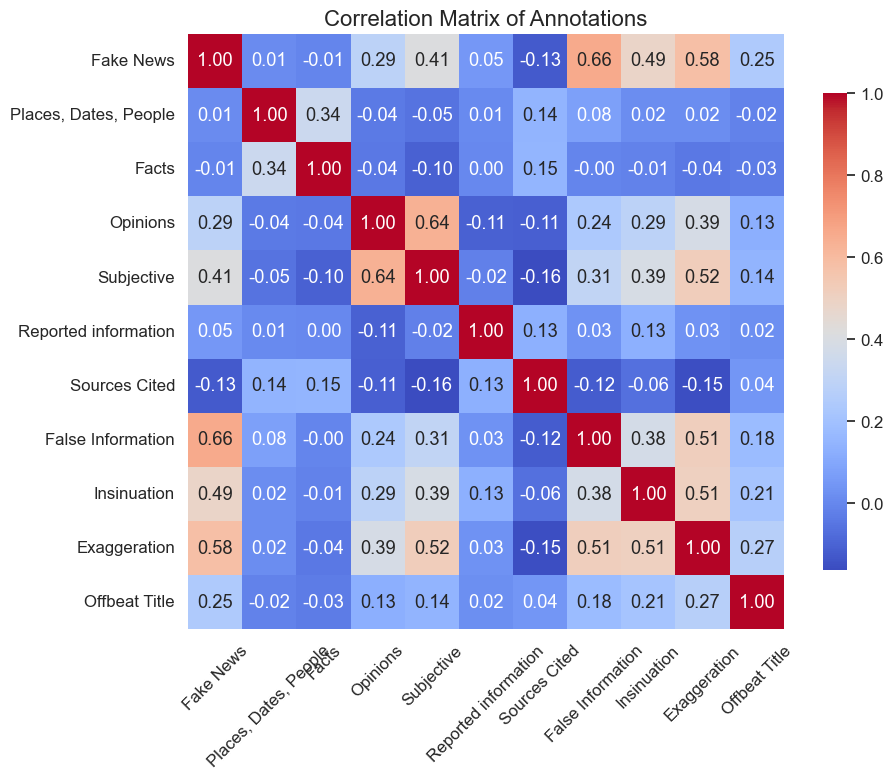

In [60]:
df_ = df[df.columns[2:13]]

df_.corr().style.background_gradient(cmap='coolwarm', low=0, high=1)
plt.figure(figsize=(10, 8))
sns.heatmap(df_.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix of Annotations", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

On s'intéresse maitenant à la matrice des co-occurrences des différents labels. Cela nous permettra de voir dans quelle mesure est-ce que certains labels sont informatifs pour en expliquer d'autres. 

/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_48361/218279233.py:10: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


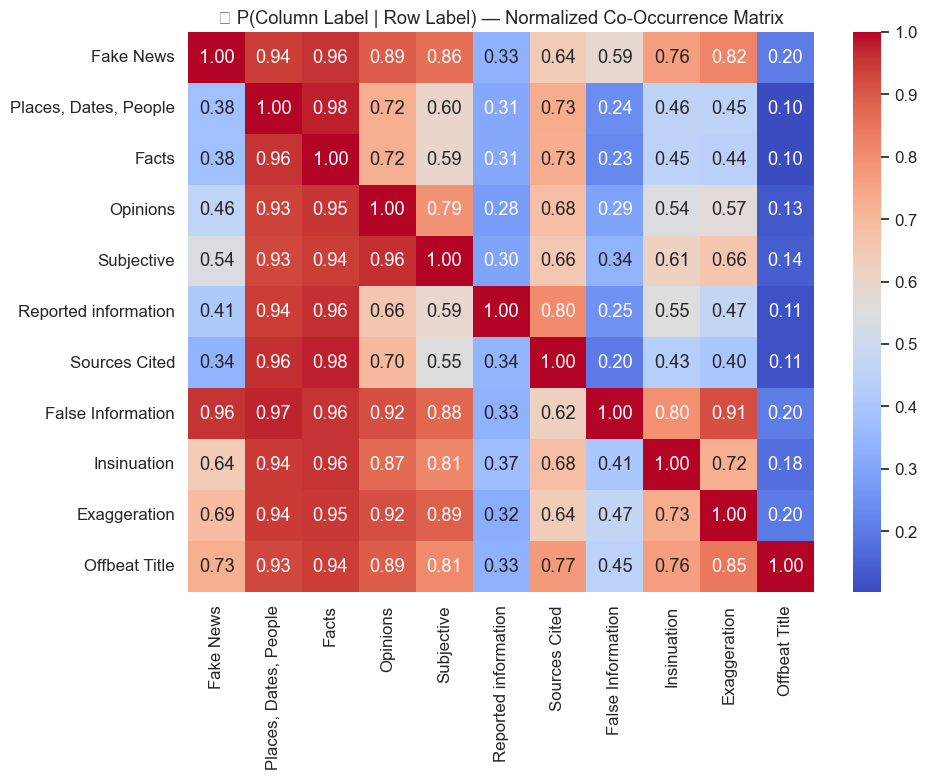

In [61]:
co_occurrence = df_.T.dot(df_) 

labels_totals = df_.sum(axis=0)

conditional = co_occurrence.div(labels_totals, axis=0)

plt.figure(figsize=(10, 8))
sns.heatmap(conditional, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("🧩 P(Column Label | Row Label) — Normalized Co-Occurrence Matrix")
plt.tight_layout()
plt.show()

Interprétation des co-occurences comme dans l'article ....

---

### *Human Annotations*

We now turn our attention to evaluating the quality and structure of the human annotations in the OBSINFOX dataset.

Specifically, we aim to:

* Assess the **consistency of the annotations** with expectations based on the dataset’s construction methodology,
* Examine the **class balance** across the different labels,
* Measure the **inter-annotator agreement**,
* Analyze the **correlation between labels** to better understand their relationships.

This analysis is a crucial step in our study, as it allows us to evaluate the **reliability and informativeness** of the labels provided. Understanding how human annotators identify fake news — and which linguistic or stylistic cues they rely on — will guide the rest of our project.

In particular, this insight will help us identify:

* Which labels are the most **discriminative** or **informative** for fake news detection,
* How closely machine learning models can replicate or differ from **human reasoning**.

Later in the project, we will compare these human-driven patterns with the predictions and internal logic of automated models, bridging the gap between human and machine interpretations of misinformation.

---
### **Topic & Genre Analysis de OBSINFOX**

scrapping manuel des textes à partir des URL, on crée des fichiers .txt que l'on feed ensuite aux modèles. 

Aller sur le site internet pour générer une free API key et faire l'analyse de TOPIC / GENRE

Dans partie, on fait des analyses directement sur les textes. 

On peut notamment regarder : 

- longueur moyenne des articles (nb de characters / nb de mots)
- longueur moyenne group by labels (longueur moyenne des articles à fake news...)
- mots les plus communs dans le corpus
- demander à chat d'autres idées....

---

Dans cette partie, on va remove les 21 articles sur le total de 100 que l'on n'a pas réussi à scrapper sur le web depuis l'URL. Cela peut être dû à une structure particulière non reconnue de la page web. Si nous avions plus de temps, on aurait pu utiliser une méthode de scrapping classique sur le Web comme ``BeautifoulSoup`` pour parser et manuellement le contenu textuel de page à partir de la structure en HTML. 

In [62]:
df_text = df.copy()
df_text.dropna(subset = ['text'], inplace=True)

In [63]:
stopwords = stopwords + ['»', '«', '–', '».', '»,']

print("Stopwords and Punctuation in Text")

print(stopwords)

Stopwords and Punctuation in Text
['d', 'du', 'mon', 'que', 'étant', 'étantes', 'aurons', 'elle', 'eues', 'eusse', 'fut', 'étante', 'fussiez', 'eux', 'seraient', 'il', 'l', 'auriez', 'ce', 'en', 'aurais', 'mes', 'eusses', 'est', 'eue', 'était', 'mais', 'aie', 'le', 'eurent', 'qui', 'fusses', 'soient', 'sont', 'son', 'sommes', 'aurait', 'eussent', 'serions', 'auront', 'dans', 'eûtes', 'serai', 'étiez', 'même', 'c', 'ai', 'eussions', 'as', 'avez', 'ces', 'ta', 'une', 'soit', 'avec', 'étais', 'eut', 's', 'leur', 'pour', 'se', 'fûtes', 'ayants', 'à', 'avais', 'ayons', 'eûmes', 'étaient', 'des', 'm', 'ont', 'te', 'es', 'serons', 'ma', 'soyons', 'y', 'je', 'vos', 'sera', 'fussent', 'fût', 'avons', 'eût', 'lui', 'avions', 'aura', 'tes', 'êtes', 'notre', 'nous', 'pas', 'seront', 'nos', 'de', 'moi', 'étants', 'la', 'fussions', 'ton', 'sur', 't', 'eu', 'sa', 'aux', 'au', 'furent', 'soyez', 'tu', 'les', 'ayant', 'un', 'aies', 'ayez', 'eussiez', 'étées', 'aurai', 'suis', 'étée', 'avait', 'sois', '

On peut donc utiliser les fonctions de preprocessing que l'on a défini au début de ce notebook sur les articles que l'on a réussi à scrapper depuis le web

In [64]:
df_text['Cleaned Text'] = df_text['text'].progress_apply(lambda x: preprocessing(x))

df_text.head()

100%|██████████| 632/632 [00:01<00:00, 394.36it/s]


,URL,Title,Fake News,"Places, Dates, People",Facts,Opinions,Subjective,Reported information,Sources Cited,False Information,Insinuation,Exaggeration,Offbeat Title,Annotator,Article ID,text,Cleaned Text
0,https://lesakerfrancophone.fr/la-relation-entr...,La relation entre la technologie et la religion,0,1,1,1,1,0,1,0,0,0,0,rater1,0,Par Austin Cline − Le 27 fevrier 2019 − Source...,austin cline − 27 fevrier 2019 − source learn ...
1,https://www.breizh-info.com/2021/01/27/157958/...,"Confinement. Les habitants de Brest, Morlaix e...",0,1,1,0,0,0,1,0,0,0,0,rater1,1,"Dans le cadre du Dry January, opération commer...","cadre dry january, opération commerciale améri..."
3,https://lezarceleurs.blogspot.com/2021/12/emma...,"Emmanuel à Olivier : « Tiens bon, on les aura ...",1,1,1,1,1,0,0,1,0,1,0,rater1,3,"Depuis le texto de Macron à Véran, en janvier ...","depuis texto macron véran, janvier 2021, feuil..."
4,https://lesakerfrancophone.fr/selon-ubs-les-pr...,"Selon UBS, les « propriétés d’assurance tant d...",0,1,1,1,1,0,1,0,0,0,0,rater1,4,Par Birch Gold Group − Le 17 février 2022 − So...,birch gold group − 17 février 2022 − source bi...
6,https://www.profession-gendarme.com/essonne-le...,Essonne : Les voleurs tombent sur des membres ...,0,1,1,0,0,0,0,0,0,0,0,rater1,6,Vue(s) : 917\n\nIllustration. (Frederic Legran...,vue(s) 917 illustration. (frederic legrand com...


---

On commence par créer une fonction qui permet d'identifier les mots les plus fréquents dans le corpus de texte. 

To better understand the vocabulary used across our corpus, we define the function `most_common()`, which extracts the **most frequently occurring words** from a collection of text documents. This is useful for exploratory analysis, such as identifying dominant themes or stylistic features.

* Takes as input a `pandas.Series` of text documents (`corpus`) and the number of top words to return (`nb_words`).
* Removes **stopwords** (commonly used words with little semantic value).
* Counts word frequencies using Python’s built-in `Counter`.
* Returns a sorted `DataFrame` of the most frequent words along with their number of occurrences.
* `collections.Counter` for word frequency counting

This function provides a quick snapshot of the **lexical landscape** of our corpus and helps guide subsequent NLP preprocessing or interpretation steps.

In [65]:
def most_common(corpus, nb_words):
  """
  Returns the chosen number of most common words in our corpus
  with their occurences number
  ------------
  Inputs : 
    corpus(pd.Series) : the corpus containing the text samples
    nb_words (int) : number of most common words to return 
  Outputs : 
    d[:nb_words] (pd.DataFrame) : most common words and their occurances in the corpus
  """
  
  articles = corpus.str.split()
  #print(articles)
  words = np.array([word for article in articles for word in article if word.lower() not in stopwords])
  counter = Counter(words)
  
  d = pd.DataFrame(counter, index=['occurrences']).transpose().reset_index()
  d.columns=['word', 'occurences']
  d = d.sort_values('occurences', ascending=False)
  
  return d[:nb_words]

In [66]:
most_common(df_text['Cleaned Text'], 20)


,word,occurences
106,a,4880
77,plus,2424
18,comme,1824
21,cette,1592
466,fait,1240
153,c’est,1184
184,tout,1120
82,si,1048
130,être,1040
306,faire,864


On peut également sortir les associations de mots les plus courantes dans les textes : les n-grams. 

In [67]:
def get_ngrams(corpus, nb_grams, nb_words):
    """
    Computes and return the chosen most n_grams of a corpus 
    """
    count = CountVectorizer(ngram_range=(nb_grams, nb_grams)).fit(corpus)
    ensemble = count.transform(corpus).sum(axis=0)
    words_freq = [(word, ensemble[0, idx]) for word, idx in count.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:nb_words]

In [68]:
def plot_unique_ngrams(ngrams_dict, num_to_show=20):
    """
    Plot side-by-side line plots of the most frequent n-grams (1, 2, 3),
    filtering out those that appear as subparts of longer n-grams.
    """

    df_dict = {
        n: pd.DataFrame(data, columns=['ngram', 'count'])
        for n, data in ngrams_dict.items()
    }

    higher_ngrams = {
        1: df_dict.get(2, pd.DataFrame())['ngram'].tolist() + df_dict.get(3, pd.DataFrame())['ngram'].tolist(),
        2: df_dict.get(3, pd.DataFrame())['ngram'].tolist(),
        3: []
    }

    for n in df_dict:
        exclusion = set(higher_ngrams[n])
        df_dict[n] = df_dict[n][~df_dict[n]['ngram'].apply(lambda x: any(x in h for h in exclusion))]

    fig, axes = plt.subplots(1, len(df_dict), figsize=(18, 8), sharey=True)

    for idx, (n, df) in enumerate(sorted(df_dict.items())):
        df = df.sort_values('count').tail(num_to_show)

        axes[idx].plot(df['count'], df['ngram'], lw=4)
        axes[idx].set_title(f"Unique {n}-grams", fontsize=18)
        axes[idx].set_xlabel("Occurrence count", fontsize=14)
        axes[idx].tick_params(labelsize=12)

        if idx == 0:
            axes[idx].set_ylabel("n-grams", fontsize=14)

    plt.tight_layout()
    plt.show()

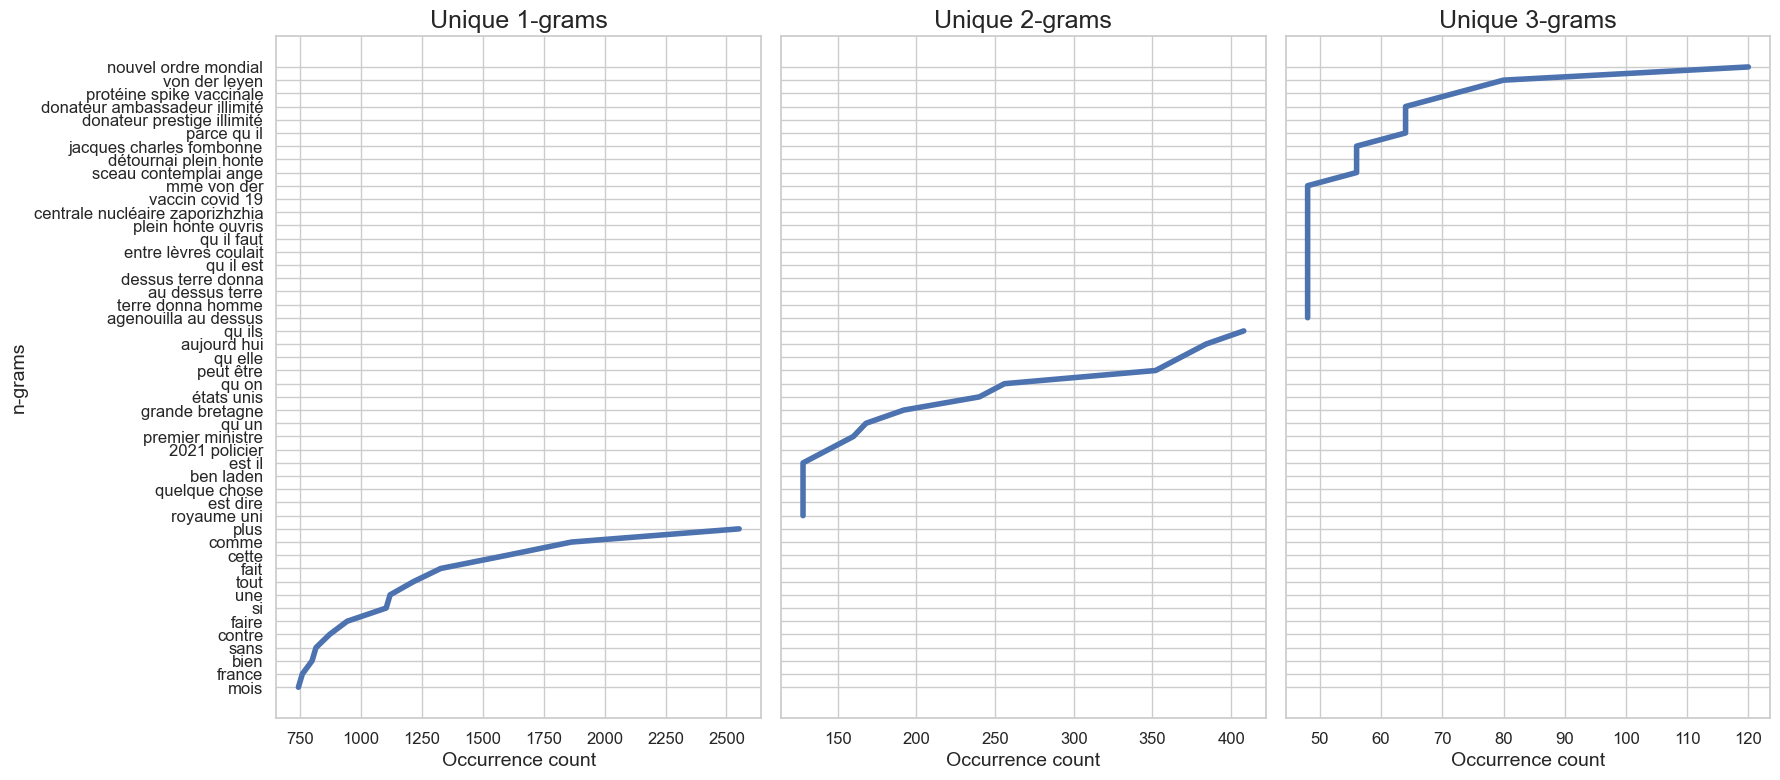

In [69]:
ngrams_dict = {
    1: get_ngrams(df_text['Cleaned Text'], 1, 20),
    2: get_ngrams(df_text['Cleaned Text'], 2, 20),
    3: get_ngrams(df_text['Cleaned Text'], 3, 20)
}

plot_unique_ngrams(ngrams_dict, num_to_show=20)

Pour terminer cette première analyse des articles, nous allons artificiellement créer des features relatives aux articles pour voir si cela peut être informatif, notamment par rapport au label ``Fake News``. 

- On ajoute la taille des articles (en nombre de mots)
- Nombre de caractères
- Taille moyenne des mots
- Nombre de chiffres
- Nombre de phrases
- Nombre de mots uniques
- Nombre de StopWords par articles

In [70]:
df_text['Number of Words'] = df_text['text'].str.split().apply(len)
df_text['Number of Characters'] = df_text['text'].str.len()
df_text['Average Word Size'] = df_text['text'].str.split().apply(lambda x: np.mean([len(w) for w in x]) if x else 0)
df_text['Number of Figures'] = df_text['Cleaned Text'].apply(lambda x: len(re.findall(r'\d', x)))
df_text['Number of Sentences'] = df_text['text'].apply(lambda x: len(re.findall(r'\.', x)))
df_text['Number of Unique Words'] = df_text['text'].apply(lambda x: len(set(x.split())))
df_text['Number of Stopwords'] = df_text['text'].apply(lambda x: len([w for w in x.split() if w in stopwords]))
df_text['Ratio of Stopwords'] = df_text['text'].apply(lambda x: len([w for w in x.split() if w in stopwords]) / len(x.split()) if len(x.split()) > 0 else 0)

df_text.head()

,URL,Title,Fake News,"Places, Dates, People",Facts,Opinions,Subjective,Reported information,Sources Cited,False Information,...,text,Cleaned Text,Number of Words,Number of Characters,Average Word Size,Number of Figures,Number of Sentences,Number of Unique Words,Number of Stopwords,Ratio of Stopwords
0,https://lesakerfrancophone.fr/la-relation-entr...,La relation entre la technologie et la religion,0,1,1,1,1,0,1,0,...,Par Austin Cline − Le 27 fevrier 2019 − Source...,austin cline − 27 fevrier 2019 − source learn ...,4565,29315,5.404600,20,179,1660,1847,0.404600
1,https://www.breizh-info.com/2021/01/27/157958/...,"Confinement. Les habitants de Brest, Morlaix e...",0,1,1,0,0,0,1,0,...,"Dans le cadre du Dry January, opération commer...","cadre dry january, opération commerciale améri...",431,2677,5.183295,70,14,252,148,0.343387
3,https://lezarceleurs.blogspot.com/2021/12/emma...,"Emmanuel à Olivier : « Tiens bon, on les aura ...",1,1,1,1,1,0,0,1,...,"Depuis le texto de Macron à Véran, en janvier ...","depuis texto macron véran, janvier 2021, feuil...",486,3036,5.218107,23,25,303,187,0.384774
4,https://lesakerfrancophone.fr/selon-ubs-les-pr...,"Selon UBS, les « propriétés d’assurance tant d...",0,1,1,1,1,0,1,0,...,Par Birch Gold Group − Le 17 février 2022 − So...,birch gold group − 17 février 2022 − source bi...,1620,10069,5.193827,42,56,781,588,0.362963
6,https://www.profession-gendarme.com/essonne-le...,Essonne : Les voleurs tombent sur des membres ...,0,1,1,0,0,0,0,0,...,Vue(s) : 917\n\nIllustration. (Frederic Legran...,vue(s) 917 illustration. (frederic legrand com...,225,1442,5.364444,7,12,153,81,0.360000


On réalise une regression logistique à partir des nouvelles features que l'on a créé sur les textes pour expliquer le label ``Fake News``. Ainsi, nous allons tenter d'identifier s'il y a des indices dans ces features qui permettent d'expliquer si les annotateurs le qualifie de Fake News. 

In [110]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Features utilisées
features = [
    'Number of Words',
    'Number of Characters',
    'Average Word Size',
    'Number of Figures',
    'Number of Sentences',
    'Number of Unique Words',
    'Number of Stopwords',
    'Ratio of Stopwords'
]

# Variable cible (assure-toi qu'elle est binaire : 0/1)
X = df_text[features]
y = df_text['Fake News']  # label = 1 pour fake news, 0 sinon

# Séparation en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [111]:
model = LogisticRegression(max_iter=1000)  # Augmente max_iter si ça ne converge pas
model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [112]:
# Prédictions
y_pred = model.predict(X_test)


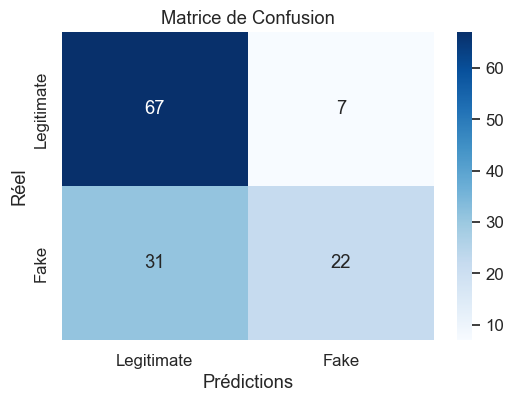

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Générer la matrice
cm = confusion_matrix(y_test, y_pred)
labels = ['Legitimate', 'Fake']

# Affichage avec seaborn
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Réel')
plt.show()


In [114]:
# Importance de chaque feature
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(coef_df)


                  Feature  Coefficient
2       Average Word Size     0.456100
7      Ratio of Stopwords     0.416140
4     Number of Sentences     0.018018
5  Number of Unique Words     0.009193
6     Number of Stopwords     0.005265
0         Number of Words    -0.003552
3       Number of Figures    -0.002398
1    Number of Characters    -0.000363


---

Puis topic / genre analysis avec Gate Cloud API et analyse group by label -> voir les thèmes où il y a le plus de fake news...

On va tester plusieurs services : 

- Genre analysis d'un article de presse
- ...

Par ailleurs, GATECLOUD est conçu pour traiter les textes brutes et donc utilise également la ponctuation...

API Key : gcqdl3pf0rx9

password : fxw4mrms6lx27d3w5ino

In [71]:
# API Setup
API_KEY = "gccsodzafd8e"
SERVICE_URL = "https://cloud-api.gate.ac.uk/process/news-genre-classifier"  


headers = {
    "Accept": "application/json",
    "Content-Type": "text/plain",  
    "GATECloud-API-Key": API_KEY
}

def analyze_with_gate(text):
    try:
        response = requests.post(
            SERVICE_URL,
            headers=headers,
            data=text.encode('utf-8'),  # texte brut
            timeout=15
        )
        response.raise_for_status()
        return response.json()
    except Exception as e:
        #print("❌ Error:", e)
        return None

results = []
for text in tqdm(df_text['text'].iloc[0:79]):
    result = analyze_with_gate(text)
    results.append(result)
    #time.sleep(2)  # To avoid hitting the API too quickly

df_text['gate_output'] = results * 8

100%|██████████| 79/79 [00:16<00:00,  4.86it/s]


In [72]:
types = ['Opinon', 'Satire', 'Reporting']

In [73]:
SERVICE_URL = "https://cloud-api.gate.ac.uk/process/persuasion-classifier"

analyze_with_gate(df_text['text'].iloc[0])

In [74]:
SERVICE_URL = "https://cloud-api.gate.ac.uk/process/hyperpartisan"

analyze_with_gate(df_text['text'].iloc[0])

---
### **Understanding Human vs Machine Caracterisation of Fake News**

Utilisation des modèles VAGO et VAGO-N pour obtenir les 3 types de score (vagueness...) et comparer les avis du modèles avec celui des annotateurs. Ensuite, dresser des conclusions sur la possibilité d'utiliser ces modèles entraînés sur de grands corpus pour inférer si oui ou non les articles sont des Fake News -> genre regarder la corrélation entre le score de vagueness et la propension des annotateurs de qualifier de fake news...

Ensuite, on peut essayer de voir des les repos comment entraîner des modèles LTSM, CNN sur le dataset même s'il est très petit pour faire de la multi-label classification. On peut comparer les résultats avec d'autres datasets, plus succints en terme de labels mais plus larges en terme de textes...

---
On peut commencer par checker à quel point les features que l'on a créées manuellement sur les textes sont utiles et corrélées aux différents labels. 

On dresse un état des lieux des corrélations et interprétations que l'on a fait pour voir ce qui était informatif pour dire qu'un texte contient une fake news. 

On passe les textes dans VAGO, VAGO-N et un autre pour voir

---

In [79]:
df_text['text'].iloc[0]

'Par Austin Cline − Le 27 fevrier 2019 − Source Learn Religions\n\nDe nombreux laïcs et non-croyants de toutes sortes ont tendance à considérer la religion et la science comme fondamentalement incompatibles. Cette incompatibilité est également imaginée pour s’étendre à la relation entre la religion et la technologie, puisque la technologie est un produit de la science et que la science ne peut pas aller de l’avant sans la technologie, surtout aujourd’hui. Ainsi, bon nombre d’athées s’émerveillent avec incrédulité du nombre d’ingénieurs qui sont également des créationnistes et du nombre de personnes dans les industries de haute technologie qui affichent de grandes motivations religieuses.\n\nMélanger technologie et religion\n\nPourquoi assistons-nous à un enchantement généralisé pour la technologie et en même temps à une résurgence mondiale du fondamentalisme religieux ? Nous ne devrions pas supposer que la montée des deux est simplement une coïncidence. Au lieu de présumer que l’éducat

In [103]:
from transformers import pipeline

# Charge un modèle de classification pour le français
classifier = pipeline("text-classification", model="tblard/tf-allocine", tokenizer="camembert-base")

# Exemple de texte
texte = "Je pense que cette décision est injuste et arbitraire."

resultat = classifier(texte)
print(resultat)

All model checkpoint layers were used when initializing TFCamembertForSequenceClassification.

All the layers of TFCamembertForSequenceClassification were initialized from the model checkpoint at tblard/tf-allocine.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertForSequenceClassification for predictions without further training.
Device set to use 0


[{'label': 'NEGATIVE', 'score': 0.9270755648612976}]


In [109]:
labels = []

for i in range(79): 
    text = df_text['text'].iloc[i]
    text = text[:512]
    result = classifier(text)
    labels.append(float(result[0]['score']))

labels

[0.8207659721374512,
 0.5256519913673401,
 0.8200979232788086,
 0.7687176465988159,
 0.6732943654060364,
 0.7114521265029907,
 0.675471305847168,
 0.9377214908599854,
 0.9152992963790894,
 0.745904266834259,
 0.7996089458465576,
 0.7991971373558044,
 0.8839090466499329,
 0.6827499866485596,
 0.7115548849105835,
 0.6455236673355103,
 0.9072914719581604,
 0.5572487115859985,
 0.6894546151161194,
 0.727092981338501,
 0.9657894968986511,
 0.537449836730957,
 0.6775148510932922,
 0.6636620759963989,
 0.5650220513343811,
 0.7930925488471985,
 0.5334943532943726,
 0.9482702016830444,
 0.6056259274482727,
 0.8480399250984192,
 0.941132664680481,
 0.7652507424354553,
 0.6091776490211487,
 0.530246913433075,
 0.5576858520507812,
 0.5112838745117188,
 0.7549839019775391,
 0.7763000726699829,
 0.6011497378349304,
 0.6381401419639587,
 0.7761046886444092,
 0.9482263922691345,
 0.9831430315971375,
 0.8495008945465088,
 0.7217596769332886,
 0.7471456527709961,
 0.9472336173057556,
 0.5920233726501465